<a href="https://colab.research.google.com/github/BLayus/marketing_analytics_case/blob/main/Marketing_Analytics_Case.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import libraries

import pandas as pd
import numpy as np
import datetime as dt
import warnings
warnings.filterwarnings("ignore")

# Data viz
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# Statistical libraries
from scipy.stats import chi2_contingency

# Kmodes clustering
!pip install kmodes
from kmodes.kmodes import KModes

# NLP
from wordcloud import WordCloud
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Applying a plot style to the charts

#plt.style.use('seaborn-v0_8')

sns.set_style('darkgrid', {'grid.color': '.8',
                           'grid.linestyle': '-',
                           'text.color': '.2',
                           'xtick.color': 'dimgray',
                           'ytick.color': 'dimgray',
                           'axes.labelcolor': 'dimgray'})

# Defining a color pallete

colors = ['midnightblue', 'grey', 'cornflowerblue', 'silver', 'lightsteelblue', 'whitesmoke']
sns.set_palette(sns.color_palette(colors))

In [3]:
# Import dataset from github repository

url = 'https://github.com/BLayus/marketing_analytics_case/blob/main/Data/analytics-case-study-data.xlsx?raw=true'

df = pd.read_excel(url)


In [4]:
# Show a sample of the loaded dataset

df.sample(5)

,Campaign ID,Campaign Name,Prospect Status,Account ID,Account Name,domain,Country,Prospect ID,Opt-In,Opt-In Source,Opt-In Timestamp,Opt-Out Timestamp,Job Title,Prospect Source
118,FY23-Q3-global-PROD461-spring_clearance_event,Spring Clearance Event,No Show,0014M0000Wnj8WrQAJ,Astral Solutions,astralsolutions.net,India,0034M0000r6sjvgQAJ,Yes,website form,2023-01-24 06:11:00,NaT,Mobile & Supply Chain QA Analyst,Trade Show
611,FY23-Q3-global-PROD461-winter_wonderland,Winter Wonderland,Responded,0014M0000f7hC3ZQAU,Phoenix Dynamics,phoenixdyn.biz,Brazil,0034M0000hEjiqNQAZ,Yes,social media campaign,2023-10-07 06:11:00,NaT,IT Application Analyst,Advertisement
841,FY23-Q3-global-PROD461-annual_summer_blowout,Annual Summer Blowout,No Show,0014M0000ZJwBVJQA2,Stellar Innovations,stellarinnov.org,France,0034M0000r2HJlPQAX,Yes,online purchase,2023-06-11 06:11:00,NaT,Data Analyst,Referral
372,FY23-Q3-global-PROD461-annual_halloween_sale,Annual Halloween Sale,Attended,0014M0000eMRa3aQAD,Horizon Technologies,horizontechnologies.net,Japan,0034M0000qHw3RgQAJ,Yes,NaN,2023-11-16 06:11:00,NaT,Data Analyst,Advertisement
777,FY23-Q3-global-PROD461-holiday_sale_extravaganza,Holiday Sale Extravaganza,No Show,0014M0000ayS5yeQAB,Skyline Solutions,skylinesolutions.org,United Kingdom,0034M0000pLki1gQAJ,Yes,online contest entry,2023-07-03 06:11:00,NaT,"""Senior Director, Financial Planning & Analysis""",Referral


In [5]:
# Looking for info, size and data types

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Campaign ID        1000 non-null   object        
 1   Campaign Name      1000 non-null   object        
 2   Prospect Status    1000 non-null   object        
 3   Account ID         1000 non-null   object        
 4   Account Name       1000 non-null   object        
 5   domain             1000 non-null   object        
 6   Country            1000 non-null   object        
 7   Prospect ID        1000 non-null   object        
 8   Opt-In             986 non-null    object        
 9   Opt-In Source      875 non-null    object        
 10  Opt-In Timestamp   954 non-null    datetime64[ns]
 11  Opt-Out Timestamp  32 non-null     datetime64[ns]
 12  Job Title          1000 non-null   object        
 13  Prospect Source    1000 non-null   object        
dtypes: dateti

##1 - Cleaning / Preparing the Data

*  A - Were there missing values? How did you complete the data?

*  B - Did you convert any data types?

*  C - What are the derived values you used?

Opt-Out Timestamp    968
Opt-In Source        125
Opt-In Timestamp      46
Opt-In                14
Campaign ID            0
Campaign Name          0
Prospect Status        0
Account ID             0
Account Name           0
domain                 0
Country                0
Prospect ID            0
Job Title              0
Prospect Source        0
dtype: int64

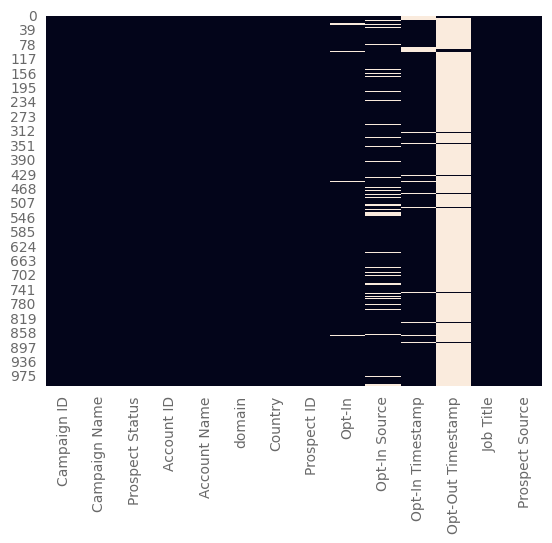

In [6]:
# Display null values with a heatmap figure and show null quantity in ascending order

sns.heatmap(df.isnull(), cbar=False)

display(df.isnull().sum().sort_values(ascending= False))

In [7]:
# Opt-in Source missing values comes from unknow source, I'll fill then with the label "Unknow"

df['Opt-In Source'] = df['Opt-In Source'].fillna('Unknow')


In [8]:
# Opt-in Timestamp and Opt-out timestamp missings are unknow dates, I'll leave then as 0
# Fill NaT values with 0

df['Opt-Out Timestamp'] = df['Opt-Out Timestamp'].fillna(0)
df['Opt-In Timestamp'] = df['Opt-In Timestamp'].fillna(0)

In [9]:
# Opt-in - is a binary (yes or no) feature, therefore it's not expected to have null values

# Replace rows that should have 'No' value as there is not an opt-in date neither an opt-out date, so the service was not used

df.loc[(df['Opt-In Timestamp'] == 0) & (df['Opt-Out Timestamp'] == 0) & (df['Opt-In'].isnull()), 'Opt-In'] = 'No'


In [10]:
# Replace the remaining rows that should have 'Yes' value as there is an opt-in date or an opt-out date, so the service was used at any moment

df.loc[df['Opt-In'].isnull(), 'Opt-In'] = 'Yes'


In [11]:
# checking if there is any remaining null

df.isnull().sum()

Campaign ID          0
Campaign Name        0
Prospect Status      0
Account ID           0
Account Name         0
domain               0
Country              0
Prospect ID          0
Opt-In               0
Opt-In Source        0
Opt-In Timestamp     0
Opt-Out Timestamp    0
Job Title            0
Prospect Source      0
dtype: int64

In [12]:
# Convert to datetime

df['Opt-In Timestamp'] = pd.to_datetime(df['Opt-In Timestamp'], errors='coerce')

df['Opt-Out Timestamp'] = pd.to_datetime(df['Opt-Out Timestamp'], errors='coerce')

In [13]:
# Verifying data types and converting datatimes

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Campaign ID        1000 non-null   object        
 1   Campaign Name      1000 non-null   object        
 2   Prospect Status    1000 non-null   object        
 3   Account ID         1000 non-null   object        
 4   Account Name       1000 non-null   object        
 5   domain             1000 non-null   object        
 6   Country            1000 non-null   object        
 7   Prospect ID        1000 non-null   object        
 8   Opt-In             1000 non-null   object        
 9   Opt-In Source      1000 non-null   object        
 10  Opt-In Timestamp   1000 non-null   datetime64[ns]
 11  Opt-Out Timestamp  1000 non-null   datetime64[ns]
 12  Job Title          1000 non-null   object        
 13  Prospect Source    1000 non-null   object        
dtypes: dateti

##2 - Data Analysis

* A - What is the mix of practitioners, decision makers and executives that showed interest in the demo for the product?

* B - The CMO is looking at performance worldwide and wants to know the
performance by regions such as LATAM, EMEA, APAC and NORTHAM

  i. Across the regions which campaigns performed the best in terms of
reach (no of prospects impacted) and engagement (the stage of the funnel)?

  ii. What sources drove the most opt-in’s for the catalog?

* C - Did you notice any patterns or anomalies in the data? Can you plot them?

In [14]:
# Investigating the job titles to find categories, there are several differnt title jobs. It's better if we can analyze this roles in groups

df['Job Title'].unique()

array(['Senior Managed Care Social Media', 'SENIOR ANALYST',
       'Data- Bij DE Gemeente Leeuwarden Analyst', 'Data Analyst',
       'Data Scientist / Analyst / Engineer', 'Vice President Analyst',
       'IT analyst', 'Business Analyst',
       'Information Technology Analyst (GRC)', 'IT Project Analyst',
       '"Information, Infrastructure Operations Technology Analyst"',
       'Technical Business Analyst', 'Digital and Data Analyst',
       'Senior Data Analyst', 'Data Analytics Specialist',
       'Senior Research Analyst',
       'Senior Business, Payroll Systems Analyst',
       'Information Security Analyst', 'Senior IT Business Analyst',
       '"Senior Director, Data & Analytics"',
       'Senior Advisor, Data and Analytics Governance',
       'Senior Privacy Security Analyst', 'Business Systems Analyst',
       'Business Intelligence Analyst', 'Business System Analyst',
       'Decision Analytics Associate', 'Sr. Data & Analytics Consultant',
       'GIS Data Analyst',
  

In [15]:
# As proposed, lets group job titles into three roles: practitioners, decision makers and executives

# New feature with job roles

df['Job_Roles'] = df['Job Title'].apply(lambda x: 'Practitioner' if 'analyst' in x.lower()
                                                  else 'Decision Maker'if 'manager' in x.lower()
                                                  else 'Executive' if 'director' or 'vice president' or 'chief' or 'head' or 'lead' or 'SVP' or 'VP' in x.lower()
                                                  else 'Other')



In [16]:
# Is the roles apply reliable?

df['Job_Roles'].value_counts()

Job_Roles
Practitioner      722
Executive         217
Decision Maker     61
Name: count, dtype: int64

In [17]:
df['Prospect Status'].value_counts()

Prospect Status
No Show       662
Registered    127
Attended      117
Responded      94
Name: count, dtype: int64

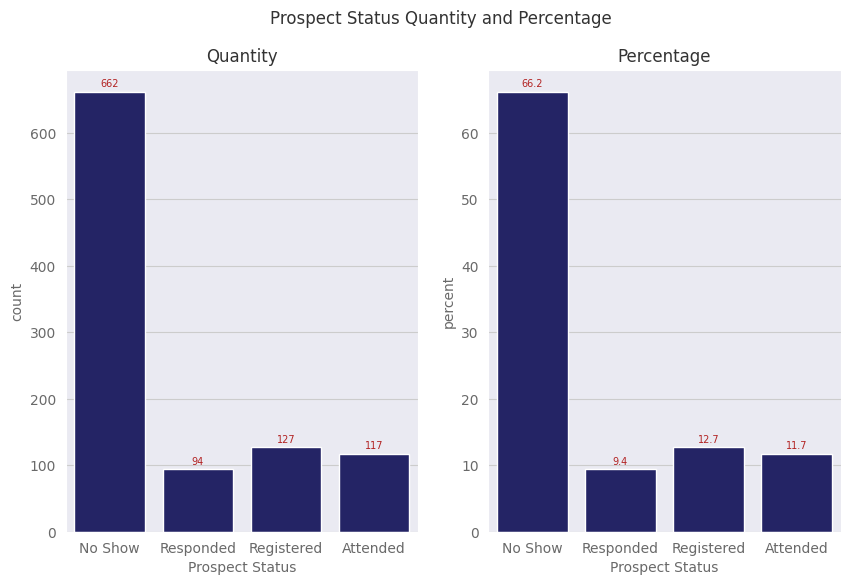

In [18]:
# Plot a chart with quantity and percentage of Prospect Status

fig, axes = plt.subplots(1,2 ,figsize=(10,6))
fig.suptitle('Prospect Status Quantity and Percentage')

ax1 = sns.countplot(x= 'Prospect Status', stat= 'count', data= df, ax=axes[0])
ax2 = sns.countplot(x= 'Prospect Status', stat= 'percent', data= df, ax= axes[1])
axes[0].set_title('Quantity')
axes[1].set_title('Percentage')

ax1.bar_label(ax1.containers[0], fontsize= 7, color='firebrick', padding= 2)
ax2.bar_label(ax2.containers[0], fontsize= 7, color='firebrick', padding= 2)

plt.show()

In [19]:
# How many professionals of each role was interested in the app demo?

filtered = df[df['Prospect Status'].isin(['Responded', 'Attended', 'Registered'])]


In [20]:
# Grouping and counting interested roles

grouped = filtered.groupby(['Job_Roles', 'Prospect Status']).size().reset_index(name='Quantity')
grouped['Percentage'] = round(grouped['Quantity'] / grouped['Quantity'].sum() * 100, 2)

display(grouped)

,Job_Roles,Prospect Status,Quantity,Percentage
0,Decision Maker,Attended,8,2.37
1,Decision Maker,Registered,6,1.78
2,Decision Maker,Responded,4,1.18
3,Executive,Attended,29,8.58
4,Executive,Registered,31,9.17
5,Executive,Responded,16,4.73
6,Practitioner,Attended,80,23.67
7,Practitioner,Registered,90,26.63
8,Practitioner,Responded,74,21.89


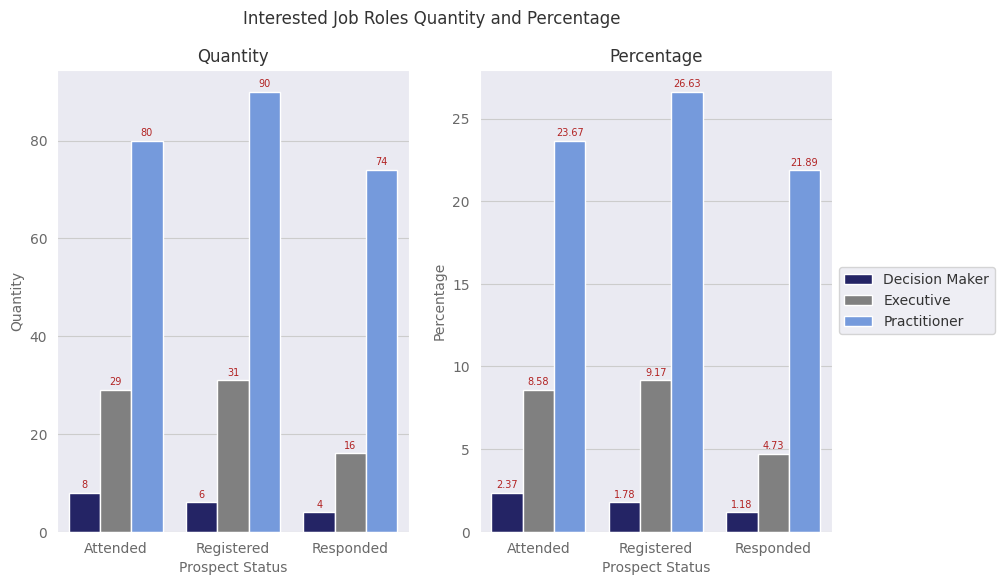

In [21]:
# Plot a chart with quantity and percentage of interested prospects only

fig, axes = plt.subplots(1,2 ,figsize=(10,6))
fig.suptitle('Interested Job Roles Quantity and Percentage')

ax1 = sns.barplot(x= 'Prospect Status', y= 'Quantity', hue= 'Job_Roles', data= grouped, ax=axes[0])
ax2 = sns.barplot(x= 'Prospect Status', y= 'Percentage', hue= 'Job_Roles', data= grouped, ax= axes[1])
axes[0].set_title('Quantity')
axes[1].set_title('Percentage')

ax1.bar_label(ax1.containers[0], fontsize= 7, color='firebrick', padding= 2)
ax1.bar_label(ax1.containers[1], fontsize= 7, color='firebrick', padding= 2)
ax1.bar_label(ax1.containers[2], fontsize= 7, color='firebrick', padding= 2)
ax2.bar_label(ax2.containers[0], fontsize= 7, color='firebrick', padding= 2)
ax2.bar_label(ax2.containers[1], fontsize= 7, color='firebrick', padding= 2)
ax2.bar_label(ax2.containers[2], fontsize= 7, color='firebrick', padding= 2)

ax1.legend(bbox_to_anchor= (1.2, 0.5), loc='center left')
ax2.legend(bbox_to_anchor= (1, 0.5), loc='center left')

plt.show()

In [22]:
# Inspecting wich countries are presented in this dataset

df['Country'].value_counts()

Country
United States     280
Canada            100
United Kingdom    100
Italy              60
India              60
Mexico             60
Spain              60
Brazil             60
China              60
Argentina          40
Japan              40
Germany            40
France             40
Name: count, dtype: int64

In [23]:
# Grouping countries by regions as pointed by CMO

df['Region'] = df['Country'].apply(lambda x: 'Latam' if x in ['Argentina', 'Brasil', 'Mexico']
                                   else 'Northam' if x in ['Canada', 'United States']
                                   else 'Emea' if x in ['United Kingdom', 'Italy', 'Spain', 'Germany', 'France']
                                   else 'Apac')

In [24]:
# Verifying that all data entries were converted to group regions

df['Region'].value_counts()

Region
Northam    380
Emea       300
Apac       220
Latam      100
Name: count, dtype: int64

In [25]:
# Grouping campaigns and regions and prospect and engagement

campaigns_reach = df.groupby(['Campaign Name', 'Region'])['Prospect ID'].count().reset_index().sort_values('Prospect ID', ascending= False)

display(campaigns_reach.head(6))

,Campaign Name,Region,Prospect ID
205,Summer Savings Extravaganza,Northam,15
24,Annual Summer Clearance,Northam,12
60,Cyber Monday Sale,Apac,12
157,Spring Break Sale,Emea,11
19,Annual Summer Blowout,Emea,10
152,New Year Discounts,Northam,10


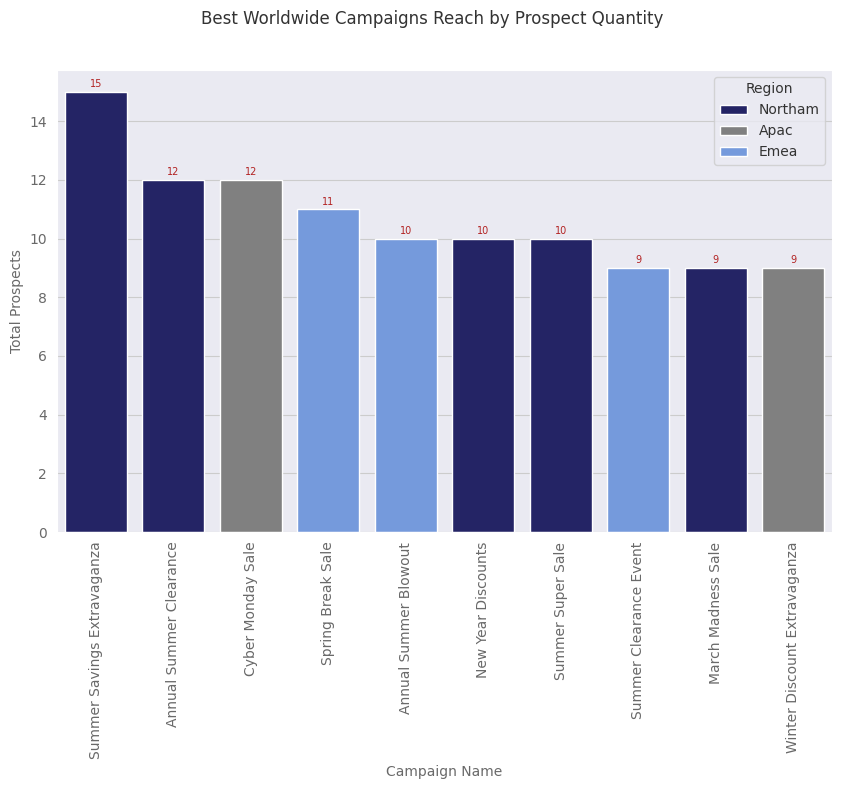

In [26]:
# Plot a chart with the reach info above

best_campaigns = campaigns_reach.head(10)

fig, axes= plt.subplots(figsize=(10,6))
fig.suptitle('Best Worldwide Campaigns Reach by Prospect Quantity')

ax1 = sns.barplot(x= 'Campaign Name', y= 'Prospect ID', hue= 'Region', data= best_campaigns)
plt.xlabel('Campaign Name')
plt.ylabel('Total Prospects')

ax1.bar_label(ax1.containers[0], fontsize= 7, color='firebrick', padding= 2)
ax1.bar_label(ax1.containers[1], fontsize= 7, color='firebrick', padding= 2)
ax1.bar_label(ax1.containers[2], fontsize= 7, color='firebrick', padding= 2)

plt.xticks(rotation=90)

plt.show()

In [27]:
# Investigating best engagement campaigns

campaigns_engagement = df[df['Prospect Status'].isin(['Responded', 'Attended', 'Registered'])].groupby(['Campaign Name', 'Region'])['Prospect ID', ].count().reset_index().sort_values('Prospect ID', ascending= False)

best_engagement = campaigns_engagement.head(10)
display(best_engagement)

,Campaign Name,Region,Prospect ID
54,Fall Favorites Discounts,Emea,9
103,Summer Savings Bonanza,Apac,7
79,New Year Discounts,Northam,7
97,Summer Blowout,Northam,7
42,Cyber Monday Sale,Apac,7
24,Annual Year End Clearance,Apac,6
67,Halloween Spooktacular,Northam,5
127,Thanksgiving Sale,Northam,5
110,Summer Showcase,Emea,4
34,Back to School Discounts,Emea,4


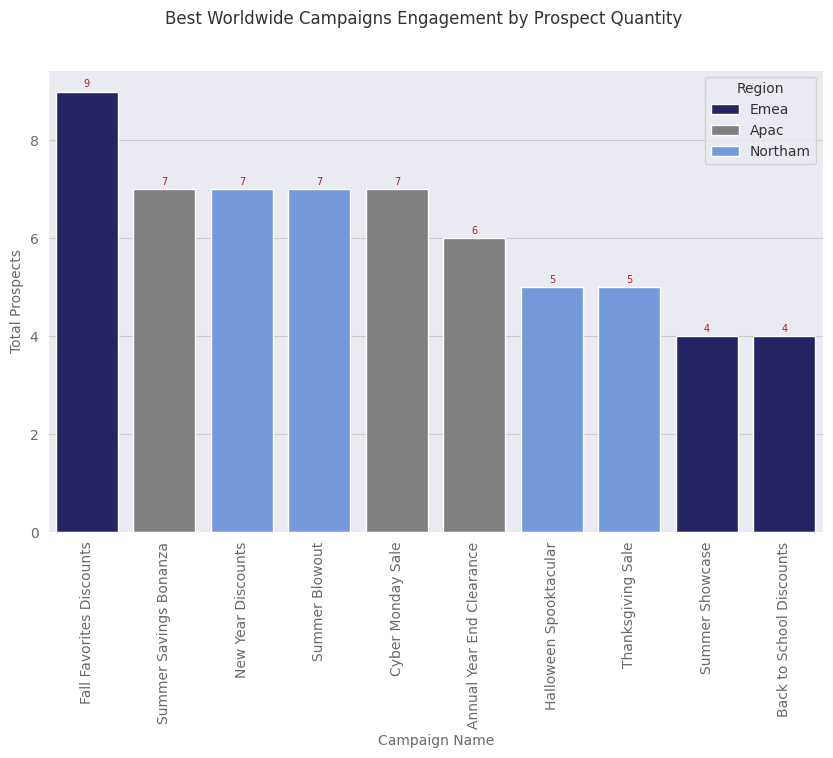

In [28]:
# Plot a chart with the engagement info

fig, axes= plt.subplots(figsize=(10,6))
fig.suptitle('Best Worldwide Campaigns Engagement by Prospect Quantity')

ax1 = sns.barplot(x= 'Campaign Name', y= 'Prospect ID', hue= 'Region', data= best_engagement)
plt.xlabel('Campaign Name')
plt.ylabel('Total Prospects')

ax1.bar_label(ax1.containers[0], fontsize= 7, color='firebrick', padding= 2)
ax1.bar_label(ax1.containers[1], fontsize= 7, color='firebrick', padding= 2)
ax1.bar_label(ax1.containers[2], fontsize= 7, color='firebrick', padding= 2)

plt.xticks(rotation=90)

plt.show()

In [29]:
best_sources = df.groupby(['Opt-In', 'Prospect Source', 'Region'])['Prospect ID'].count().reset_index().sort_values('Prospect ID', ascending= False)

best_sources = best_sources[best_sources['Opt-In'] == 'Yes']

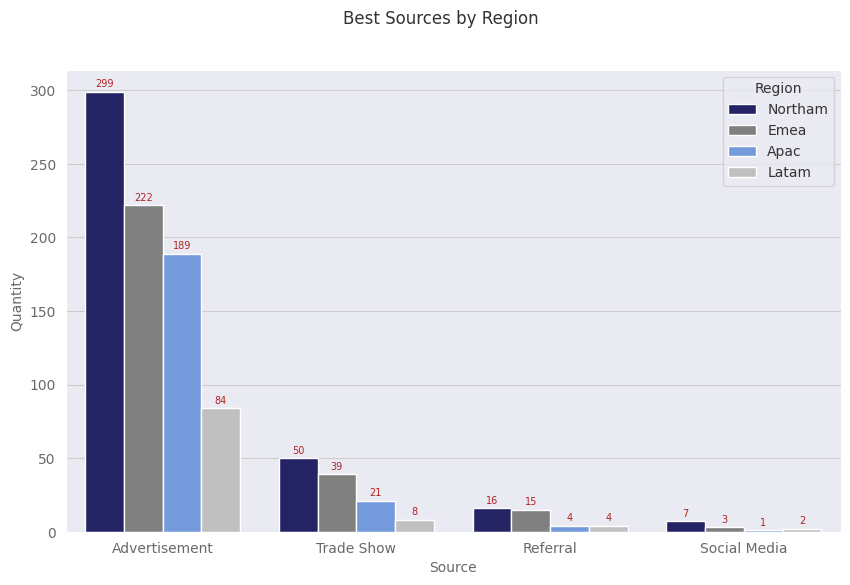

In [30]:
# Investigating what kind of source brings the most opt-ins for the customer base

fig, axes= plt.subplots(figsize=(10,6))
fig.suptitle('Best Sources by Region')

ax1 = sns.barplot(x= 'Prospect Source' , y='Prospect ID', hue= 'Region', estimator= 'sum', errorbar=None, data= best_sources)
plt.xlabel('Source')
plt.ylabel('Quantity')

ax1.bar_label(ax1.containers[0], fontsize= 7, color='firebrick', padding= 2)
ax1.bar_label(ax1.containers[1], fontsize= 7, color='firebrick', padding= 2)
ax1.bar_label(ax1.containers[2], fontsize= 7, color='firebrick', padding= 2)
ax1.bar_label(ax1.containers[3], fontsize= 7, color='firebrick', padding= 2)

plt.xticks(rotation=0)

plt.show()

In [45]:
# Analysing possible patterns or anomalies sazonality hidden in the dataset

opt_in_yes = df[df['Opt-In'] == 'Yes']


In [46]:
opt_in_yes['Opt-In Timestamp']= pd.to_datetime(opt_in_yes['Opt-In Timestamp'], errors= 'coerce')
opt_in_yes['Opt-Out Timestamp']= pd.to_datetime(opt_in_yes['Opt-Out Timestamp'], errors= 'coerce')

In [47]:
# Analysing Opt-In Timestamp X Opt-Out Timestamp ina chart

# Set the order of the months
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

opt_in_yes['Opt-In Timestamp'] = pd.Categorical(opt_in_yes['Opt-In Timestamp'].dt.month_name(locale= 'en_US.utf8'), categories=months, ordered=True)
opt_in_yes['Opt-Out Timestamp'] = pd.Categorical(opt_in_yes['Opt-Out Timestamp'].dt.month_name(locale= 'en_US.utf8'), categories=months, ordered=True)


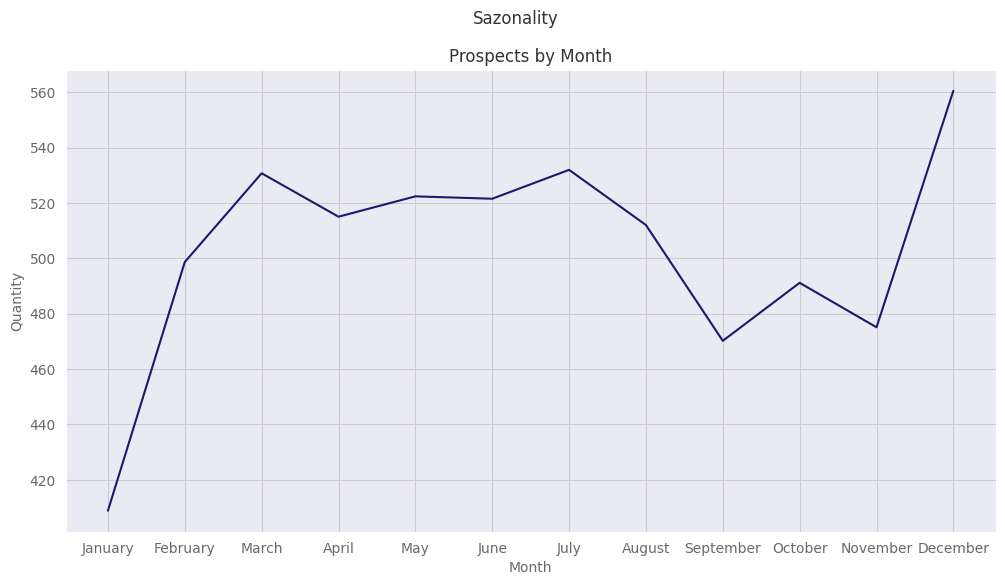

In [65]:
# Plot sazonality

fig, axes= plt.subplots(figsize=(12,6))

sns.lineplot(data=opt_in_yes, x= 'Opt-In Timestamp', y= opt_in_yes.index, ci= None)
fig.suptitle('Sazonality')
plt.title('Prospects by Month')
plt.xlabel('Month')
plt.ylabel('Quantity')

plt.show()

###Searching for Similarities and Anomalys Using Cluster Analysis

* Trial using clusterization with KModes to identify similarities and differences in the dataset.

* KModes can handle categorical data, as it uses mode instead of mean to group clusters.

* After the cluster were created, we will search for common characteristics that belongs to each group.

In [33]:
df_KModes = df[['Campaign Name', 'Prospect Status', 'Account Name', 'domain', 'Country',
               'Prospect ID', 'Opt-In', 'Opt-In Source', 'Opt-In Timestamp', 'Opt-Out Timestamp',
               'Job Title', 'Prospect Source', 'Job_Roles', 'Region']]

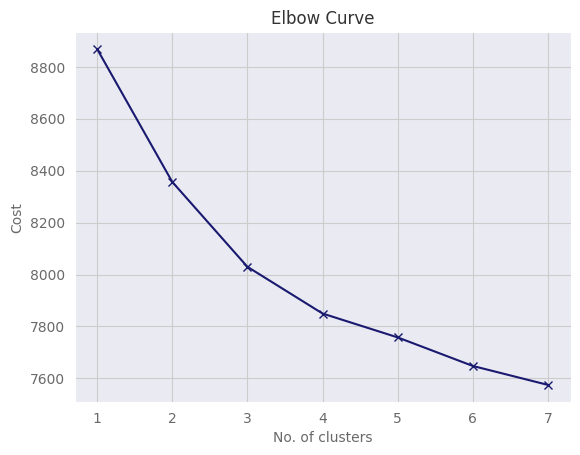

In [34]:
# Elbow curve to find optimal K
cost = []
K = range(1,8)
for k in list(K):
    kmode = KModes(n_clusters=k, init = "random", n_init = 5, verbose=0)
    kmode.fit_predict(df_KModes)
    cost.append(kmode.cost_)

plt.plot(K, cost, 'x-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Curve')
plt.show()

In [35]:
# Building the model with 4 clusters
kmode = KModes(n_clusters=4, init = "random", n_init = 5, verbose=0)
clusters = kmode.fit_predict(df_KModes)
clusters

array([2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 0, 2, 2, 0, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 2, 3, 3, 3,
       3, 3, 3, 3, 3, 2, 3, 1, 3, 1, 1, 3, 3, 0, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 3, 3, 2, 0, 0, 3, 3, 2, 3, 3, 3, 1, 3, 0, 3, 0, 3,
       2, 3, 3, 3, 0, 3, 1, 3, 0, 3, 3, 0, 0, 3, 3, 2, 3, 3, 3, 3, 3, 3,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 3,

In [36]:
df_KModes['Cluster_KModes'] = clusters

In [38]:
# What differentiates each group?

C0= df_KModes[df_KModes['Cluster_KModes'] == 0]

C1= df_KModes[df_KModes['Cluster_KModes'] == 1]

C2= df_KModes[df_KModes['Cluster_KModes'] == 2]

C3= df_KModes[df_KModes['Cluster_KModes'] == 3]


#### Group Cluster 0

* This group concentrates users that has No Show status, comes from Advertisement campaigns, has Practitioner roles and from EMEA Region.

In [39]:
display(C0['Job_Roles'].value_counts())
display(C0['Prospect Source'].value_counts())
display(C0['Country'].value_counts())
display(C0['Region'].value_counts())
display(C0['Opt-In'].value_counts())
display(C0['Opt-In Source'].value_counts())
display(C0['Prospect Status'].value_counts())
display(C0['Campaign Name'].value_counts())

Job_Roles
Practitioner      97
Executive         36
Decision Maker    10
Name: count, dtype: int64

Prospect Source
Advertisement    120
Trade Show        15
Referral           6
Social Media       2
Name: count, dtype: int64

Country
Mexico       60
Argentina    40
Canada       14
France        8
Italy         7
Spain         6
India         5
Brazil        2
Germany       1
Name: count, dtype: int64

Region
Latam      100
Emea        22
Northam     14
Apac         7
Name: count, dtype: int64

Opt-In
Yes    141
No       2
Name: count, dtype: int64

Opt-In Source
newsletter subscription    53
Unknow                     19
referral program           15
social media campaign      11
online contest entry       10
online purchase            10
website form                9
event registration          8
email subscription          8
Name: count, dtype: int64

Prospect Status
No Show       95
Registered    21
Attended      18
Responded      9
Name: count, dtype: int64

Campaign Name
Summer Super Sale               15
Annual Halloween Sale            6
Fall Fashion Sale                5
Summer Splash Sale               5
Summer Sizzler                   4
Back to School Sale              4
Summer Spectacular               4
Valentine's Day Special          4
Winter Clearance                 4
Annual Fall Sale                 4
Cyber Monday Blowout             4
Winter Wonderland                4
Summer Festival Sale             4
Annual Fall Clearance            3
Annual Year End Clearance        3
Winter Discount Extravaganza     3
Cyber Monday Madness             3
Summer Blowout Sale              3
March Madness Sale               3
Summer Savings Extravaganza      3
Labor Day Sale                   3
Spring Clearance Event           3
Back to School Discounts         2
Summer Blowout                   2
Winter Wonderland Sale           2
Annual Summer Blowout            2
End of Summer Clearance          2
Spring Flower Sale               2
Annual

#### Group Cluster 1

* This group concentrates users that has Opt-In status equals to Yes, comes from Advertisement prospect sources from several kinds of campaigns, has Executive roles and are mostly from North America NORTHAM.

In [40]:
display(C1['Job_Roles'].value_counts())
display(C1['Prospect Source'].value_counts())
display(C1['Country'].value_counts())
display(C1['Region'].value_counts())
display(C1['Opt-In'].value_counts())
display(C1['Opt-In Source'].value_counts())
display(C1['Prospect Status'].value_counts())
display(C1['Campaign Name'].value_counts())

Job_Roles
Practitioner      181
Executive          52
Decision Maker     15
Name: count, dtype: int64

Prospect Source
Advertisement    220
Trade Show        22
Social Media       3
Referral           3
Name: count, dtype: int64

Country
China      60
Brazil     58
India      54
Japan      40
Italy      11
Canada     10
Spain       9
Germany     4
France      2
Name: count, dtype: int64

Region
Apac       212
Emea        26
Northam     10
Name: count, dtype: int64

Opt-In
Yes    243
No       5
Name: count, dtype: int64

Opt-In Source
Unknow                     59
online purchase            34
online contest entry       32
social media campaign      30
referral program           24
event registration         24
website form               16
email subscription         15
newsletter subscription    14
Name: count, dtype: int64

Prospect Status
No Show       160
Attended       38
Registered     29
Responded      21
Name: count, dtype: int64

Campaign Name
Cyber Monday Sale            13
Annual Holiday Sale           8
Summer Savings Bonanza        8
Annual Year End Clearance     8
Spring Clearance Event        8
                             ..
Annual Halloween Sale         1
Summer Showcase               1
Summer Splash Event           1
Thanksgiving Sale             1
Summer Spectacular            1
Name: count, Length: 69, dtype: int64

#### Group Cluster 2

* This group concentrates users that are mostly from USA, NORTHAM Region, comes from Advertisement Prospect Sources, has made their decision to Opt-In due to Social Media and newsletter campaigns, most of them are signed as No Show status.

In [41]:
display(C2['Job_Roles'].value_counts())
display(C2['Prospect Source'].value_counts())
display(C2['Country'].value_counts())
display(C2['Region'].value_counts())
display(C2['Opt-In'].value_counts())
display(C2['Opt-In Source'].value_counts())
display(C2['Prospect Status'].value_counts())
display(C2['Campaign Name'].value_counts())

Job_Roles
Practitioner      192
Executive          63
Decision Maker      8
Name: count, dtype: int64

Prospect Source
Advertisement    203
Trade Show        42
Referral          15
Social Media       3
Name: count, dtype: int64

Country
United Kingdom    100
Spain              45
Italy              42
Germany            35
France             30
Canada             10
India               1
Name: count, dtype: int64

Region
Emea       252
Northam     10
Apac         1
Name: count, dtype: int64

Opt-In
Yes    242
No      21
Name: count, dtype: int64

Opt-In Source
online contest entry       52
referral program           40
social media campaign      35
online purchase            32
email subscription         28
event registration         26
website form               19
newsletter subscription    16
Unknow                     15
Name: count, dtype: int64

Prospect Status
No Show       175
Responded      33
Registered     33
Attended       22
Name: count, dtype: int64

Campaign Name
Annual Summer Blowout        11
Valentine's Day Special       9
Spring Break Sale             9
Summer Sizzle Sale            8
Summer Blowout                8
                             ..
Annual Year End Clearance     1
Summer Splash Event           1
Holiday Savings Bash          1
Fall Into Savings             1
End of Summer Blowout         1
Name: count, Length: 73, dtype: int64

#### Group Cluster 3

* This group concentrates users that are mostly from Brasil and China, LATAM and APAC Regions, comes from Advertisement Prospect Sources, has made their decision to Opt-In due to Social Media and Online Subscription campaigns, most of them are signed as No Show status, all of them had Opt-In.

In [42]:
display(C3['Job_Roles'].value_counts())
display(C3['Prospect Source'].value_counts())
display(C3['Country'].value_counts())
display(C3['Region'].value_counts())
display(C3['Opt-In'].value_counts())
display(C3['Opt-In Source'].value_counts())
display(C3['Prospect Status'].value_counts())
display(C3['Campaign Name'].value_counts())

Job_Roles
Practitioner      252
Executive          66
Decision Maker     28
Name: count, dtype: int64

Prospect Source
Advertisement    278
Trade Show        46
Referral          16
Social Media       6
Name: count, dtype: int64

Country
United States    280
Canada            66
Name: count, dtype: int64

Region
Northam    346
Name: count, dtype: int64

Opt-In
Yes    338
No       8
Name: count, dtype: int64

Opt-In Source
online purchase            49
social media campaign      49
referral program           46
newsletter subscription    41
website form               40
email subscription         33
Unknow                     32
online contest entry       30
event registration         26
Name: count, dtype: int64

Prospect Status
No Show       232
Registered     44
Attended       39
Responded      31
Name: count, dtype: int64

Campaign Name
Summer Savings Extravaganza    15
Annual Summer Clearance        10
New Year Discounts              9
March Madness Sale              9
Annual Year End Clearance       9
                               ..
Labor Day Special               1
Harvest Time Discounts          1
Halloween Special               1
Spring Into Savings             1
Summer Spectacular              1
Name: count, Length: 80, dtype: int64

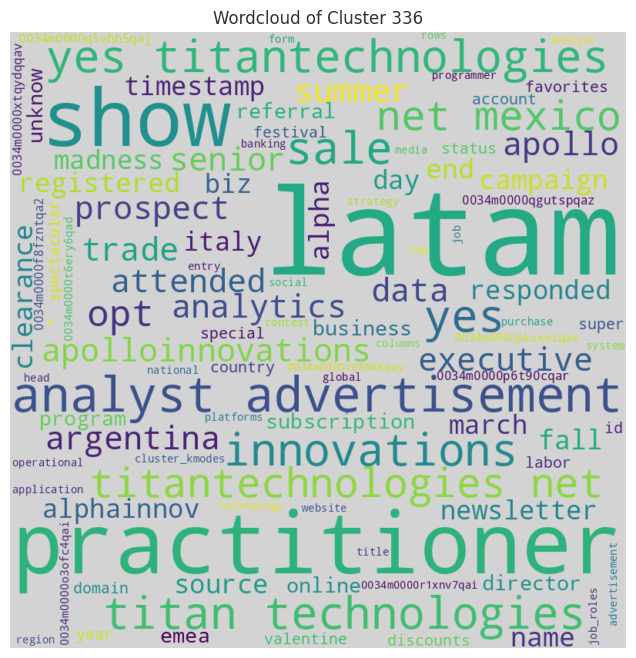

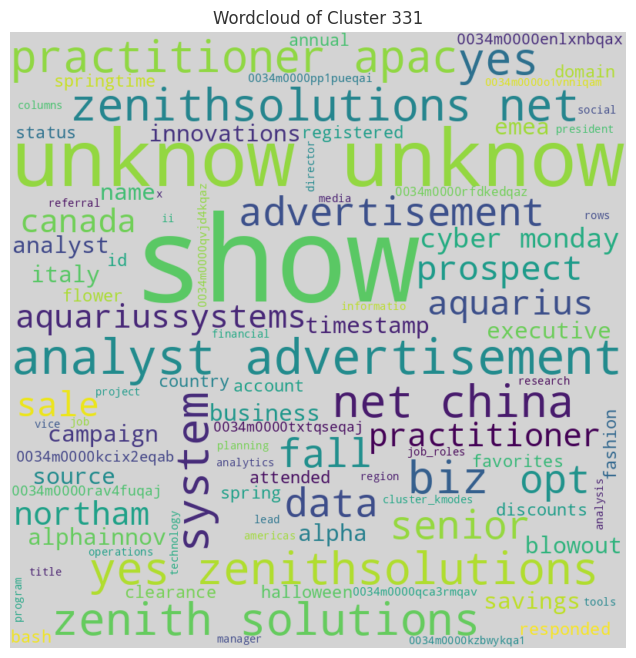

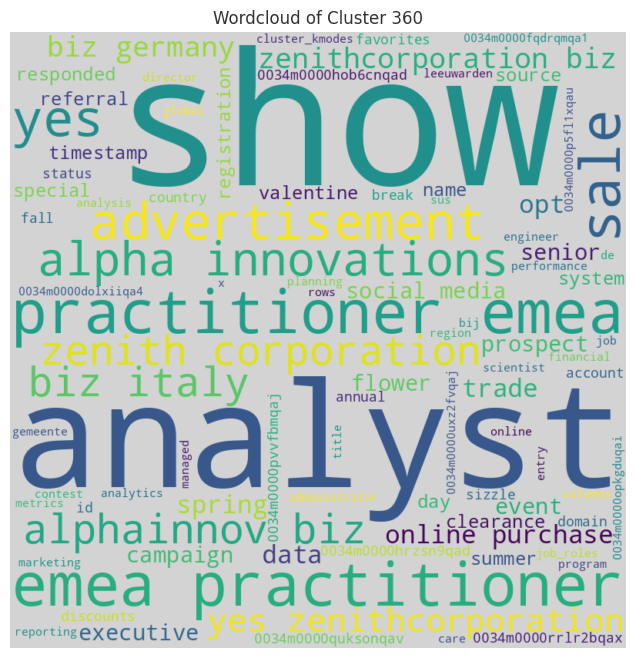

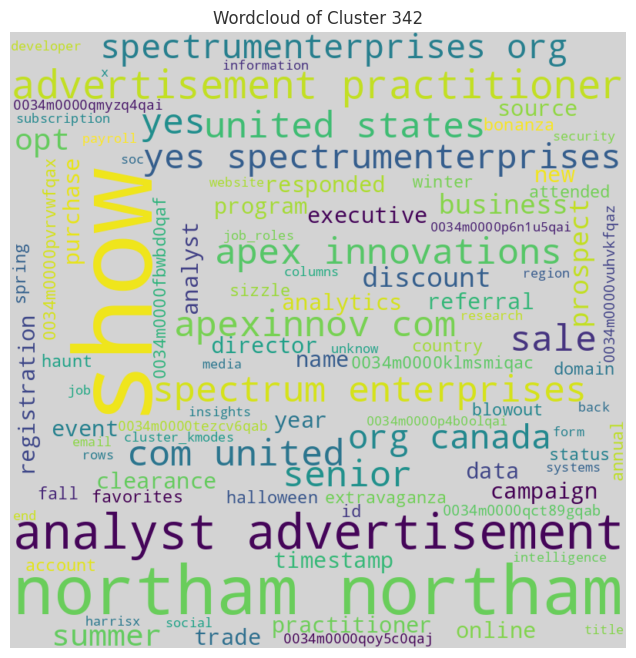

In [43]:
# Plot word clouds from each cluster, to visualize their characteristics

nlp = set(stopwords.words('english'))

for val in [C0, C1, C2, C3]:
  comment_words = ''
  val= str(val)
  tokens = val.split()

  for i in range(len(tokens)):
    tokens[i]= tokens[i].lower()

  comment_words += " ".join(tokens)+" "

  wordcloud = WordCloud(width = 800, height = 800,
                background_color ='lightgray',
                stopwords = nlp,
                min_font_size = 10).generate(comment_words)

  plt.figure(figsize=(10, 8))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.title(f'Wordcloud of Cluster {i}')
  plt.show()


##3 -  Statistical Techniques (optional)

A. What influences the free trial sign ups?

B. Is there a correlation between the prospects job title and their interest?

C. Are there any regional considerations?

In [44]:
# The subscriptio happens when the customer is registered in Prospect Status

df['Subscription'] = np.where(df['Prospect Status'] == 'Registered', 1, 0)


# What's the difference in distribution of customers wich are registered or not in each professional role?
# The null hypothesis is there are no significant differences between the distribution of each group

# Create a crosstab table, contingency table to test if there are differences

contingency_table = pd.crosstab(df['Job_Roles'], df['Subscription'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

display(contingency_table)
display(chi2, p, expected)

# since p-value is less than chi2 (0,612 < 0,979), we dont have sufficient evidences to reject the null hypothesis

# There is no significative statistical evidence to affirm that the
# distribution between job roles that registered to the service are different from the ones who didn't sign the service

Subscription,0,1
Job_Roles,,
Decision Maker,55,6
Executive,186,31
Practitioner,632,90


0.9792635413643869

0.6128520227225889

array([[ 53.253,   7.747],
       [189.441,  27.559],
       [630.306,  91.694]])

In [45]:
# Interpretation of statistical A / B test

stat, p, dof, expected = chi2_contingency(contingency_table)

prob= 0.95
alpha= 1 - prob
if p <= alpha:
  print('Dependent (reject null hypothesis)')
else:
  print('Independent (fail to reject null hypothesis)')

# As we fail to reject the null hypothesis, it means that there is no significant difference
# between the conversion rate in different professional roles

Independent (fail to reject null hypothesis)


In [46]:
dist_cont_table = pd.DataFrame(contingency_table).reset_index()


In [47]:
dist_cont_table.columns = ['Job_Roles', 'Non_Registered', 'Registered']

In [48]:
display(dist_cont_table)

,Job_Roles,Non_Registered,Registered
0,Decision Maker,55,6
1,Executive,186,31
2,Practitioner,632,90


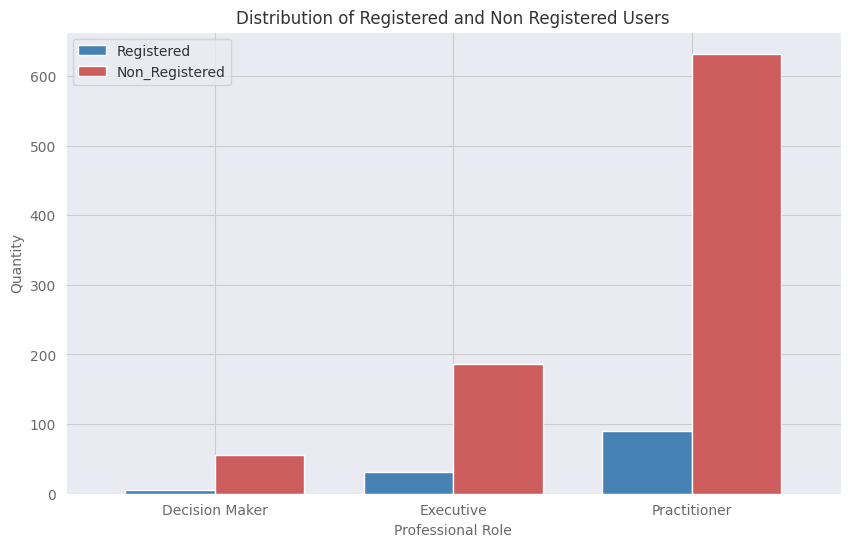

In [49]:

fig, ax = plt.subplots(figsize= (10, 6))

dist_cont_table.plot(x= 'Job_Roles', y= ['Registered', 'Non_Registered'], kind= 'bar',
            ax= ax, fill= True, color= ['steelblue', 'indianred'], width= 0.75)

ax.set_title('Distribution of Registered and Non Registered Users')
ax.set_xlabel('Professional Role')
ax.set_ylabel('Quantity')
ax.legend()
plt.xticks(rotation=0)

plt.show()


In [50]:
# What is the percentage of conversion for each professional role?

dist_cont_table['Percent_Conversion_Rate'] = round(dist_cont_table['Registered'] / (dist_cont_table['Registered'] + dist_cont_table['Non_Registered']) * 100, 2)

dist_cont_table

,Job_Roles,Non_Registered,Registered,Percent_Conversion_Rate
0,Decision Maker,55,6,9.84
1,Executive,186,31,14.29
2,Practitioner,632,90,12.47


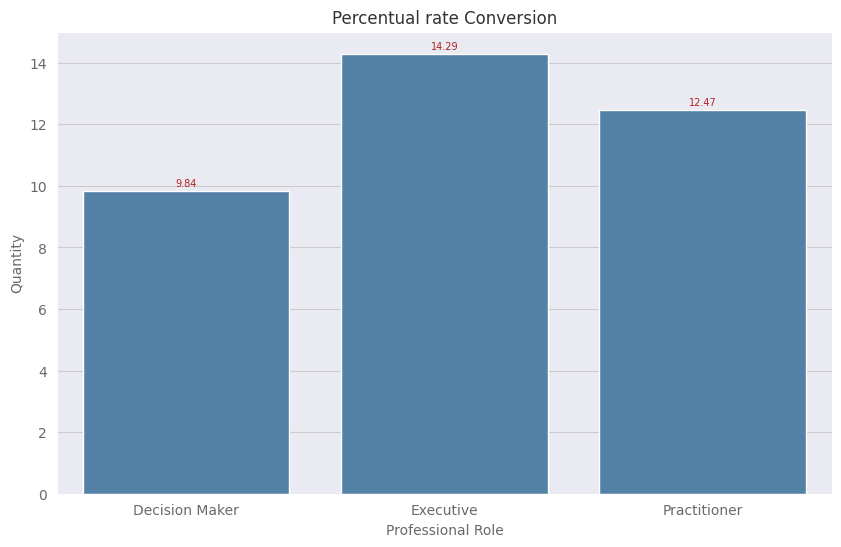

In [51]:
# Plot a chart with percentual conversion rate

fig, ax = plt.subplots(figsize= (10, 6))

sns.barplot(x= 'Job_Roles', y= 'Percent_Conversion_Rate', data= dist_cont_table, color= 'steelblue' )

ax.set_title('Percentual rate Conversion')
ax.set_xlabel('Professional Role')
ax.set_ylabel('Quantity')
ax.bar_label(ax.containers[0], fontsize= 7, color='firebrick', padding= 2)
plt.xticks(rotation=0)

plt.show()

In [52]:
# Let's analyze the same way, looking this time for possible differences in regions

# Create a crosstab table, contingency table to test if there are differences
regions_cont_table = pd.crosstab(df['Region'], df['Subscription'])

chi2, p, dof, expected = chi2_contingency(regions_cont_table)

display(regions_cont_table)
display(chi2, p, dof, expected)

# Interpretation of statistical A / B test for Regions

prob= 0.95
alpha= 1 - prob
if p <= alpha:
  print('Dependent (reject null hypothesis)')
else:
  print('Independent (fail to reject null hypothesis)')

# As we fail to reject the null hypothesis, it means that there is no significant difference
# between the conversion rate in different regions worldwide

Subscription,0,1
Region,,
Apac,194,26
Emea,261,39
Latam,86,14
Northam,332,48


0.3326854404137676

0.9537684516040348

3

array([[192.06,  27.94],
       [261.9 ,  38.1 ],
       [ 87.3 ,  12.7 ],
       [331.74,  48.26]])

Independent (fail to reject null hypothesis)


In [53]:
regions_cont_table = pd.DataFrame(regions_cont_table).reset_index()

regions_cont_table

Subscription,Region,0,1
0,Apac,194,26
1,Emea,261,39
2,Latam,86,14
3,Northam,332,48


In [54]:
regions_cont_table.columns = ['Region', 'Non_Registered', 'Registered']

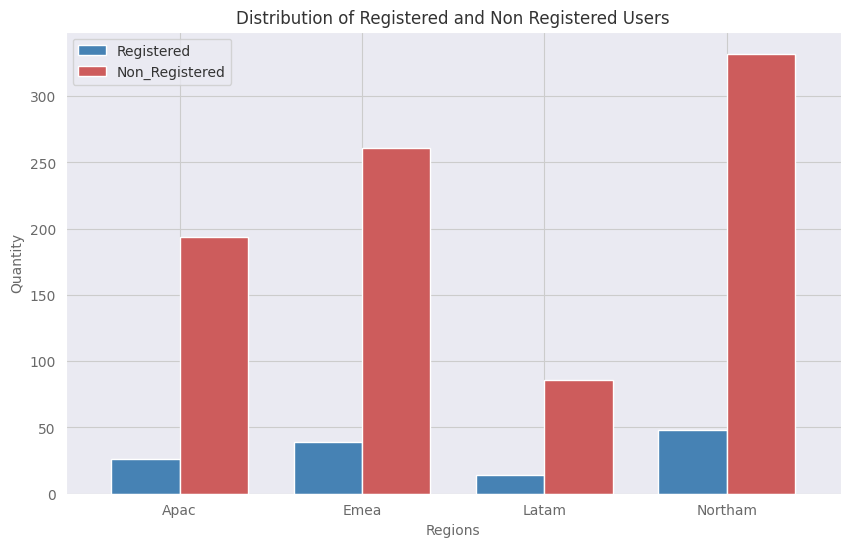

In [55]:
# Plot a chart with regions

fig, ax = plt.subplots(figsize= (10, 6))

regions_cont_table.plot(x= 'Region', y= ['Registered', 'Non_Registered'], kind= 'bar',
            ax= ax, fill= True, color= ['steelblue', 'indianred'], width= 0.75)

ax.set_title('Distribution of Registered and Non Registered Users')
ax.set_xlabel('Regions')
ax.set_ylabel('Quantity')
ax.legend()
plt.xticks(rotation=0)

plt.show()


In [56]:
# What is the percentage of conversion for Region?

regions_cont_table['Percent_Conversion_Rate'] = round(regions_cont_table['Registered'] / (regions_cont_table['Registered'] + regions_cont_table['Non_Registered']) * 100, 2)

regions_cont_table

,Region,Non_Registered,Registered,Percent_Conversion_Rate
0,Apac,194,26,11.82
1,Emea,261,39,13.00
2,Latam,86,14,14.00
3,Northam,332,48,12.63


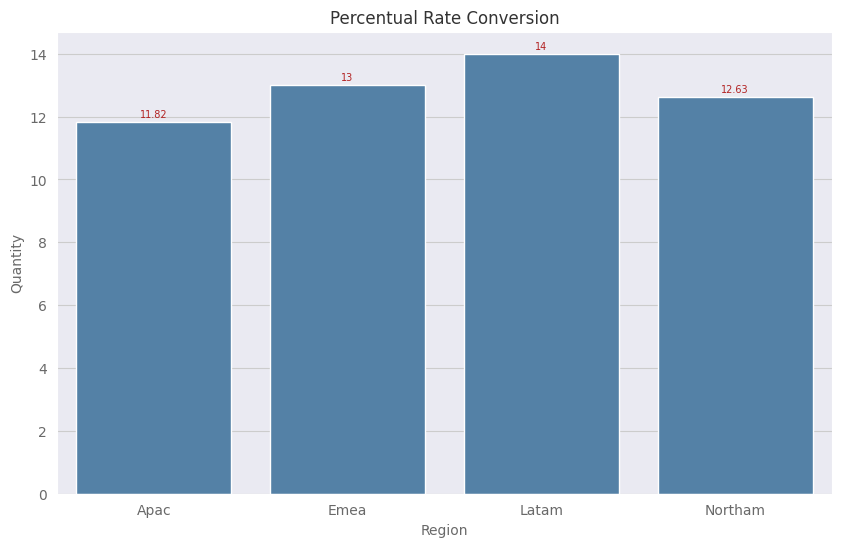

In [57]:
# Plot a chart with percentual conversion rate by Region

fig, ax = plt.subplots(figsize= (10, 6))

sns.barplot(x= 'Region', y= 'Percent_Conversion_Rate', data= regions_cont_table, color= 'steelblue' )

ax.set_title('Percentual Rate Conversion')
ax.set_xlabel('Region')
ax.set_ylabel('Quantity')
ax.bar_label(ax.containers[0], fontsize= 7, color='firebrick', padding= 2)
plt.xticks(rotation=0)

plt.show()

####Conclusion about descriptive statistical exploratory analysis

* When we consider different professional roles, there is no significant statistical differences between conversion rates

* The same applies to different regions, there's similar percentual rate conversion, around 9% to 14%.

##4 - Data Visualization

Few things to consider for data visualization:

A - Which marketing campaigns are the most successful?

B - Which prospect shows the most interest and engagement with the product?

C - Investigate the differences in the prospect characteristics and behaviors
between the most successful campaign and the rest.

In [58]:
# In this session, let's calculate the conversion rate for each marketing campaign

# Group data in campaigns to sum total conversion from free trial to subscription

campaign_rates = df.groupby('Campaign Name')['Subscription'].sum().sort_values(ascending= False)

display(campaign_rates)


Campaign Name
Annual Fall Clearance        14
Winter Clearance             12
End of Summer Blowout         7
Annual Holiday Sale           7
Annual Year End Clearance     7
                             ..
Fall Harvest Discounts        0
Fall Fever Special            0
Fall Festival Special         0
Fall Favorites Sale           0
Holiday Sale Extravaganza     0
Name: Subscription, Length: 81, dtype: int64

In [59]:

df_campaign_rates = pd.DataFrame(campaign_rates)

df_campaign_rates['Percent_Rate'] = df_campaign_rates['Subscription'] / df_campaign_rates['Subscription'].sum() * 100

df_campaign_rates.head(10)
top10_campaign_rates = df_campaign_rates.head(10)



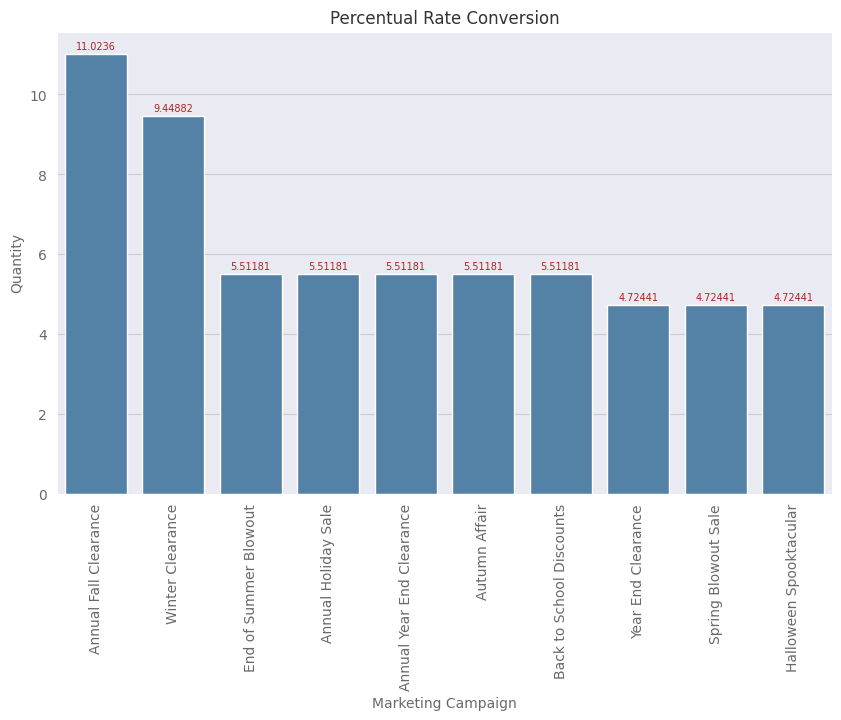

In [60]:
# Plot a chart with percentual conversion rate by Marketing campaign

fig, ax = plt.subplots(figsize= (10, 6))

sns.barplot(x= 'Campaign Name', y= 'Percent_Rate', data= top10_campaign_rates, color= 'steelblue' )

ax.set_title('Percentual Rate Conversion')
ax.set_xlabel('Marketing Campaign')
ax.set_ylabel('Quantity')
ax.bar_label(ax.containers[0], fontsize= 7, color='firebrick', padding= 2)
plt.xticks(rotation=90)

plt.show()

In [61]:
campaign_role2 = df.groupby(['Job_Roles'])['Prospect Status'].value_counts(normalize=True) *100

df_campaign_role2 = pd.DataFrame(campaign_role2).reset_index()

display(df_campaign_role2)

# Practitioners are the professionals which creates large amounts of contacts through all conversion funnel
# They are superior in numbers, but not in conversion rates

,Job_Roles,Prospect Status,proportion
0,Decision Maker,No Show,70.491803
1,Decision Maker,Attended,13.114754
2,Decision Maker,Registered,9.836066
3,Decision Maker,Responded,6.557377
4,Executive,No Show,64.976959
5,Executive,Registered,14.285714
6,Executive,Attended,13.364055
7,Executive,Responded,7.373272
8,Practitioner,No Show,66.204986
9,Practitioner,Registered,12.465374


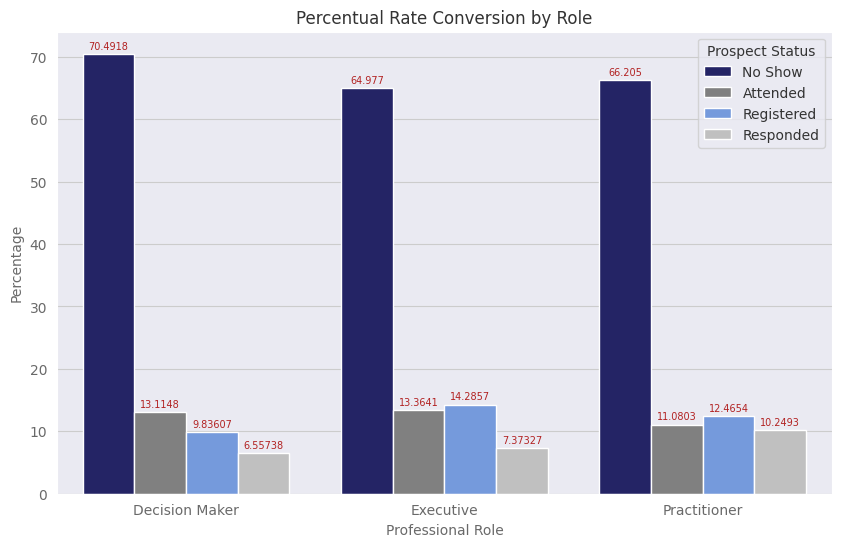

In [62]:
# Plot a chart with percentual conversion rate by Role

fig, ax = plt.subplots(figsize= (10, 6))

sns.barplot(x= 'Job_Roles', y= 'proportion',hue= 'Prospect Status', data= df_campaign_role2 )

ax.set_title('Percentual Rate Conversion by Role')
ax.set_xlabel('Professional Role')
ax.set_ylabel('Percentage')
ax.bar_label(ax.containers[0], fontsize= 7, color='firebrick', padding= 2)
ax.bar_label(ax.containers[1], fontsize= 7, color='firebrick', padding= 2)
ax.bar_label(ax.containers[2], fontsize= 7, color='firebrick', padding= 2)
ax.bar_label(ax.containers[3], fontsize= 7, color='firebrick', padding= 2)

plt.xticks(rotation=0)

plt.show()

In [63]:
campaign_role = df.groupby(['Prospect Status', 'Campaign Name'])['Job_Roles'].value_counts()

display(campaign_role)

Prospect Status  Campaign Name          Job_Roles     
Attended         Annual Fall Sale       Practitioner      6
                                        Executive         1
                 Annual Halloween Sale  Executive         5
                                        Practitioner      2
                 Annual Summer Blowout  Practitioner      6
                                                         ..
Responded        Summer Sizzle Sale     Decision Maker    1
                 Summer Sizzler         Practitioner      4
                                        Executive         1
                 Winter Wonderland      Practitioner      3
                                        Executive         2
Name: count, Length: 262, dtype: int64

In [64]:
df_campaign_role= pd.DataFrame(campaign_role).reset_index()

df_campaign_role['Percent_Rate'] = df_campaign_role['count'] / df_campaign_role['count'].sum() * 100

# Separate best and worst dataset
best_campaigns = df_campaign_role.sort_values(by= ['count', 'Campaign Name', 'Job_Roles'], ascending= False)
worst_10_campaigns = df_campaign_role.sort_values(by= ['count', 'Campaign Name', 'Job_Roles'], ascending= True)

# Excluding campaigns with zero prospects from worst campaigns
worst_campaigns_clean = worst_10_campaigns[worst_10_campaigns['count'] >=1]

# Sort only the best and worst results
chart_best = best_campaigns
chart_worst = worst_campaigns_clean

display(chart_best, chart_worst)


,Prospect Status,Campaign Name,Job_Roles,count,Percent_Rate
144,No Show,Springtime Savings,Practitioner,16,1.6
183,No Show,Winter Discount Extravaganza,Practitioner,15,1.5
175,No Show,Summer Super Sale,Practitioner,15,1.5
155,No Show,Summer Festival Sale,Practitioner,14,1.4
191,No Show,Winter Wonderland Sale,Practitioner,13,1.3
...,...,...,...,...,...
197,Registered,Annual Holiday Sale,Executive,1,0.1
50,No Show,Annual Holiday Sale,Decision Maker,1,0.1
1,Attended,Annual Fall Sale,Executive,1,0.1
195,Registered,Annual Fall Clearance,Decision Maker,1,0.1


,Prospect Status,Campaign Name,Job_Roles,count,Percent_Rate
233,Responded,Annual Clearance Event,Decision Maker,1,0.1
195,Registered,Annual Fall Clearance,Decision Maker,1,0.1
1,Attended,Annual Fall Sale,Executive,1,0.1
50,No Show,Annual Holiday Sale,Decision Maker,1,0.1
197,Registered,Annual Holiday Sale,Executive,1,0.1
...,...,...,...,...,...
191,No Show,Winter Wonderland Sale,Practitioner,13,1.3
155,No Show,Summer Festival Sale,Practitioner,14,1.4
175,No Show,Summer Super Sale,Practitioner,15,1.5
183,No Show,Winter Discount Extravaganza,Practitioner,15,1.5


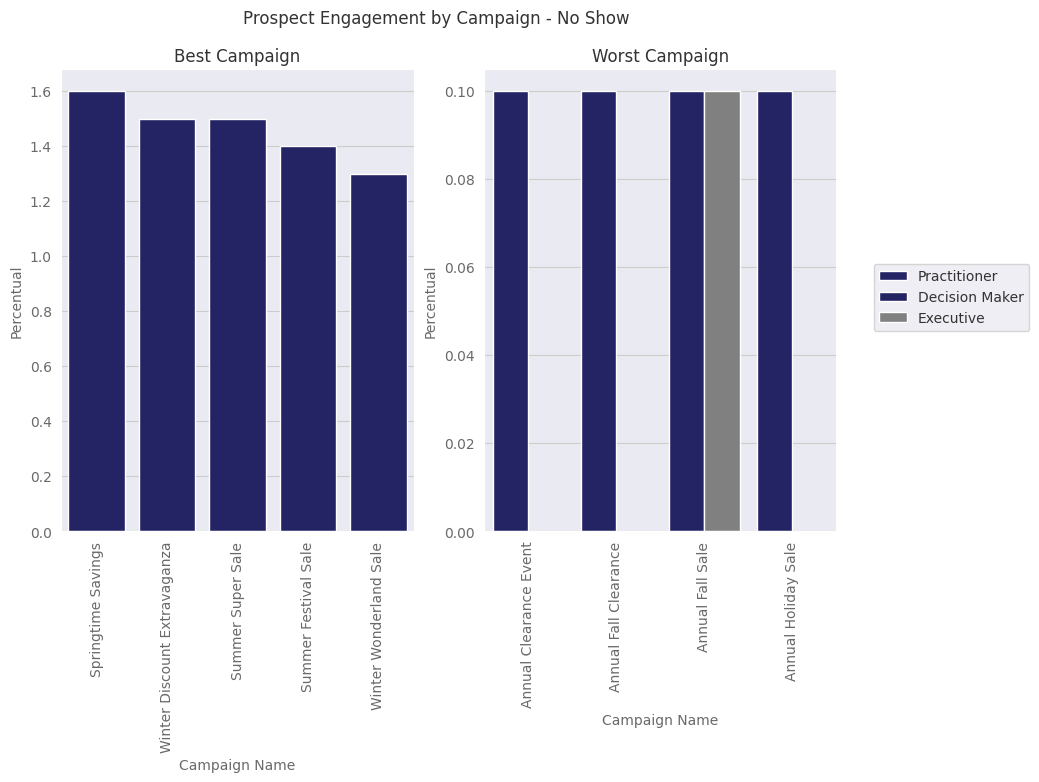

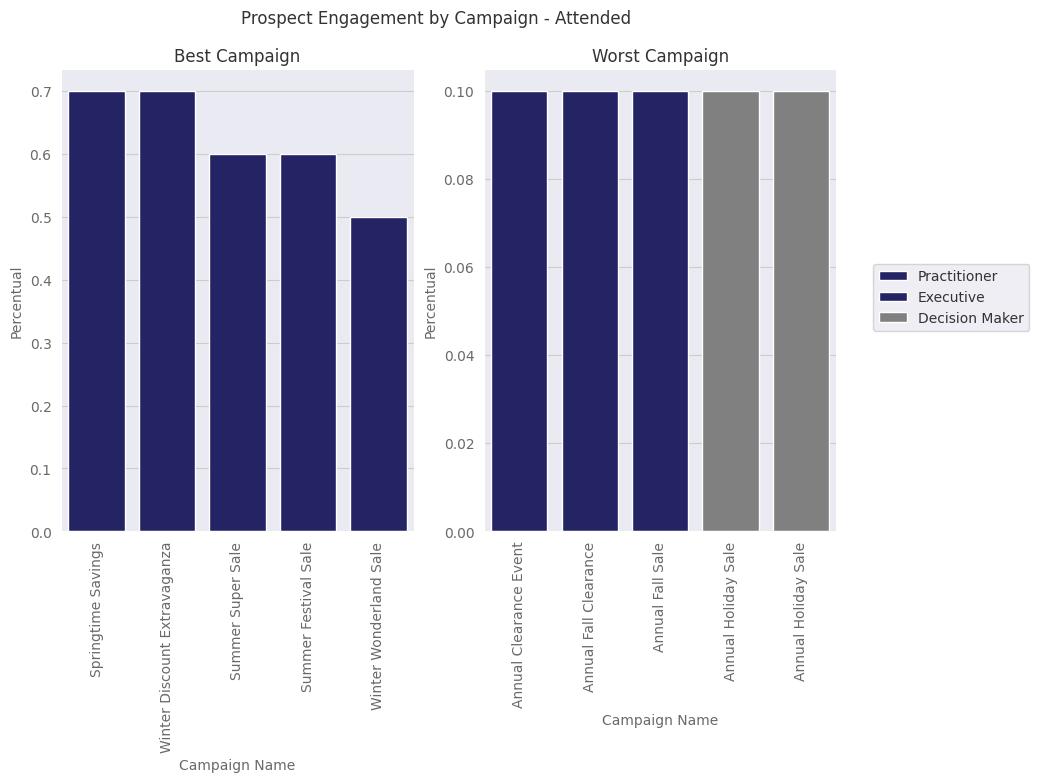

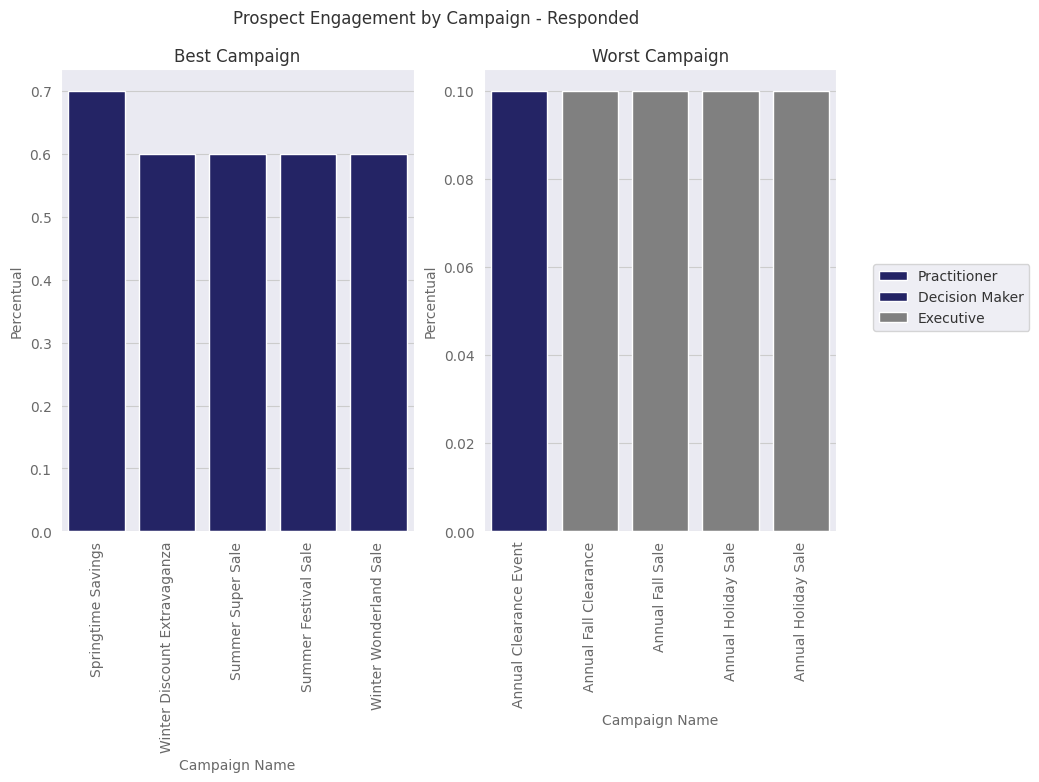

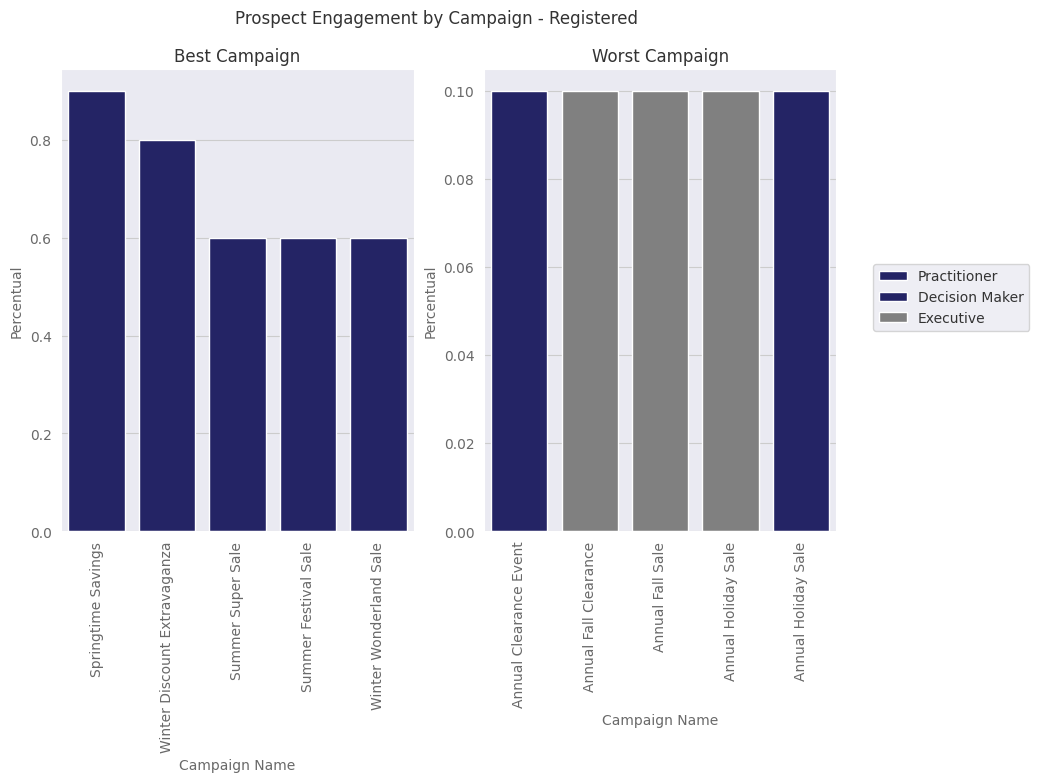

In [65]:
# Plot a chart with percentual conversion rate by Role with different status

status= ['No Show', 'Attended', 'Responded', 'Registered']

for s in status:

  fig, axes = plt.subplots(1, 2, figsize= (10, 6))

  ax1 = sns.barplot(x= 'Campaign Name', y= 'Percent_Rate', hue= 'Job_Roles',
                    data= chart_best[chart_best['Prospect Status'] == s].iloc[:5], ax= axes[0])

  ax2 = sns.barplot(x= 'Campaign Name', y= 'Percent_Rate',hue= 'Job_Roles',
                    data= chart_worst[chart_worst['Prospect Status'] == s].iloc[0:5], ax= axes[1])

  fig.suptitle(f'Prospect Engagement by Campaign - {s}')
  axes[0].set_title('Best Campaign')
  axes[1].set_title('Worst Campaign')

  ax1.set_xlabel('Campaign Name')
  ax1.set_ylabel('Percentual')

  ax2.set_xlabel('Campaign Name')
  ax2.set_ylabel('Percentual')

  campaign_best_names = chart_best['Campaign Name'].tolist()
  campaign_worst_names = chart_worst['Campaign Name'].tolist()

  ax1.tick_params(axis='x', labelrotation = 90)
  ax1.set_xticklabels(campaign_best_names)

  ax2.set_xticklabels(campaign_worst_names)
  ax2.tick_params(axis='x', labelrotation = 90)

  ax1.legend_= None
  ax2.legend_= None
  fig.legend(loc='center right', bbox_to_anchor=(1.1, 0.5), bbox_transform=plt.gcf().transFigure)

  plt.show()
